## **Brain  mask segmentation with Deep Learning**







L'objectif de cet atelier est de tester un reseau unet "basique" pour la segmentation d'une IRM de cerveau.

principaux packages python utilisés:
Tensorflow et Keras pour le deeplearning
nibabel pour la manipulation de volume 3D au format nifti
numpy et matplotlib

Le training sera réalisé avec une base de données d'images pondérées T1w d'un seul volume 3D (splitté en 146 coupes 2D) et leur masque associé (masque binaire: 1 = cerveau , 0 = other)

Le testing sera réalisé sur deux bases de données différentes, cad la même base de données training et une autre base de données  d'un seul volume 3D (un sujet) composé de 69 coupes T1w et masques associés.

Le premier exercice consistera à entrainer le reseau unet à partir d'une seule image et evaluer les performances.
Le second exercice consistera à mettre en évidence l'apport du DA pour améliorer les performances et la robustesse du réseau.

In [1]:
import tensorflow as tf
#from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import *
import tensorflow
import matplotlib.pyplot as plt
import nibabel as nib
from keras import backend as K
from keras.layers import Dropout, Lambda
import os 

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,BatchNormalization,concatenate,ReLU,LeakyReLU,Add,Activation,Input,MaxPool2D,MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D,AveragePooling2D,UpSampling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from skimage.transform import resize
from scipy.spatial.distance import directed_hausdorff
import numpy as np

Installer package gdown (via pip) pour télécharger des archives de google drive

https://clay-atlas.com/us/blog/2021/07/01/python-en-gdown-package-download-file-google-drive/

In [2]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
!gdown https://drive.google.com/uc?id=17gb7VFUgoHzUWc3eH_gxdmNekLLZQEIO
!gdown https://drive.google.com/uc?id=16-bZCe4whMnMfBjXBZwhPS16Uxet_x07



Downloading...
From: https://drive.google.com/uc?id=17gb7VFUgoHzUWc3eH_gxdmNekLLZQEIO
To: c:\Users\Jalil\Desktop\Ecole\M2TSI\initiation_segm\training.zip

  0%|          | 0.00/3.00M [00:00<?, ?B/s]
100%|██████████| 3.00M/3.00M [00:00<00:00, 32.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=16-bZCe4whMnMfBjXBZwhPS16Uxet_x07
To: c:\Users\Jalil\Desktop\Ecole\M2TSI\initiation_segm\testing.zip

  0%|          | 0.00/2.40M [00:00<?, ?B/s]
100%|██████████| 2.40M/2.40M [00:00<00:00, 28.8MB/s]


In [8]:
!unzip training
!unzip testing


'unzip' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.
'unzip' n'est pas reconnu en tant que commande interne
ou externe, un programme ex�cutable ou un fichier de commandes.


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Q1: Ecrire une fonction qui lit un couple d'image (T1,mask) au format "nii.gz" d'un dataset (training ou testing),
entrées: path, index

Utilisez nib.load
variable t1, mask pour la lecture
et get_fdata() pour récupérer la matrice image

la fonction zfill pour gérer l'index:
txt = "50"
x = txt.zfill(10)
print(x)

In [2]:
def read_image_nii(folder, index):
  t1= nib.load(os.path.join(folder, 'T1_' + str(index).zfill(4) + '.nii.gz'))
  mask = nib.load(os.path.join(folder, 'mask_' + str(index).zfill(4) + '.nii.gz'))
  t1_data=t1.get_fdata()
  mask_data=mask.get_fdata()
  return (t1_data,mask_data)

2D image size: 


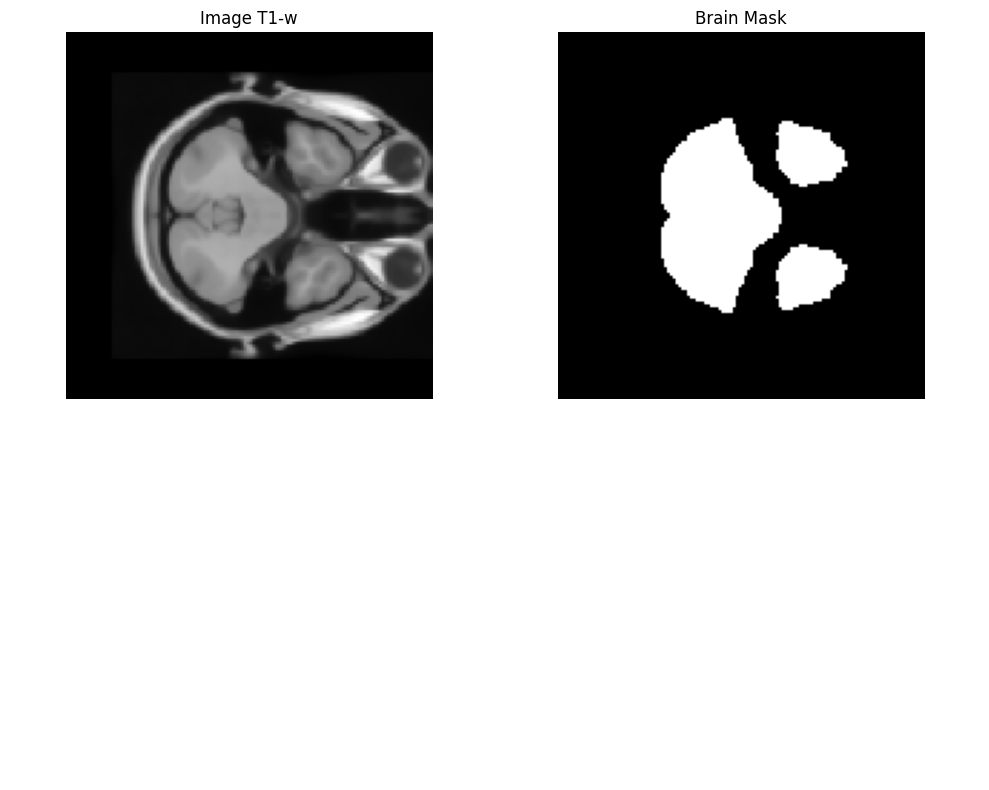

In [3]:
mon_index = 20

t1_data,mask_data=read_image_nii("../datasets/tp1_segm/training", mon_index)
print("2D image size: ")

plt.figure(figsize=(10,8))
plt.axis('Off')
plt.subplot(2,2,1)
plt.imshow(t1_data, cmap="gray", origin="lower")
plt.title('Image T1-w')
plt.axis('off')
plt.subplot(2,2,2)
plt.title("Brain Mask")
plt.imshow(mask_data, cmap="gray", origin="lower")
plt.axis('Off')
plt.tight_layout()
plt.show()

In [4]:
#recupérer le nombre d'images dans la base training

path_train, dirs_train, files_train = next(os.walk("../datasets/tp1_segm/training"))
path_test, dirs_test, files_test = next(os.walk("../datasets/tp1_segm/testing"))

nb_images_train = len(files_train)//2
nb_images_test = len(files_test)//2

print(f'nb_images_train : {nb_images_train}')
print(f'nb_images_test : {nb_images_test}')

nb_images_train : 146
nb_images_test : 69


Q2: Créer deux tableaux X_train,Y_train au format numpy de taille (mon_index,128,128,1) qui stockent respectivement les images T1w et masques binaires.

Créer deux tableaux X_test,Y_test au format numpy de taille (nb_images - 1,128,128,1) qui stockent respectivement les images T1w et masques binaires.


Attention:
could not broadcast input array from shape (128,128) into shape (128,128,1)
-> use image_data = np.expand_dims(image_data, axis=-1)


Nous allons réaliser deux fonctions, une s'occupéra de récupérer tout le jeu de données et la seconde récupèrera quelques images. Nous voulons tester d'entrainer notre modèle sur une grande base de données ainsi que sur une petite afin de comparer les résultats et voir s'il n'est pas plus pertinant de sur apprendre sur la base pour ce problème.

In [79]:
# Importing all images for training and test

X_train = np.empty((nb_images_train, 128, 128))
y_train = np.empty((nb_images_train, 128, 128))

X_test = np.empty((nb_images_test, 128, 128))
y_test = np.empty((nb_images_test, 128, 128))

for index in range(nb_images_train):
    X_train[index], y_train[index] = read_image_nii(path_train, index=index)

for index in range(nb_images_test):
    X_test[index], y_test[index] = read_image_nii(path_test, index=index)

X_train = np.expand_dims(X_train, axis=-1)
y_train = np.expand_dims(y_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)


In [80]:
print(X_train.shape)
print(X_test.shape)

(146, 128, 128, 1)
(69, 128, 128, 1)


In [30]:
# Importing images for training

mon_index = [0, 10, 15]
path = '../datasets/tp1_segm/training'
nb_images = len(os.listdir(path)) // 2

index_train = 0
index_test = 0

X_train = np.zeros((len(mon_index), 128, 128, 1))
y_train = np.zeros((len(mon_index), 128, 128, 1))

X_test = np.zeros((nb_images - len(mon_index) , 128, 128, 1))
y_test = np.zeros((nb_images - len(mon_index) , 128, 128, 1))

for sujet_index in range(0,nb_images):
  t1_data,mask_data=read_image_nii(path, sujet_index)

  mask_data = np.expand_dims(mask_data, axis=-1)
  t1_data = np.expand_dims(t1_data, axis=-1)

  if sujet_index in mon_index:
    X_train[index_train] = t1_data
    y_train[index_train] = mask_data
    index_train+=1

  else:
    X_test[index_test] = t1_data
    y_test[index_test] = mask_data
    index_test+=1

print("parsing dataset done !")

parsing dataset done !


In [31]:
print(X_train.shape)
print(X_test.shape)

(3, 128, 128, 1)
(143, 128, 128, 1)


In [26]:
# Description of U-Net

inputs = Input((128, 128, 1))
drop_out=0.0

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(drop_out) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(drop_out) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(drop_out) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(drop_out) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(drop_out) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(drop_out) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(drop_out) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(drop_out) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(drop_out) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

In [27]:
# Description of model to use

model = Model(inputs=[inputs], outputs=[outputs])
#test other loss function (loss=dice_coef_loss)
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ dropout_3[0][0] 

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
y_train.shape

(146, 128, 128, 1)

In [33]:
# Unet training
valid=0.0 # data validation percentage rate
earlystopper = EarlyStopping(patience=50, verbose=1)
#checkpointer = ModelCheckpoint('my_model_unet_mask_segmentation.h5', verbose=1, save_best_only=True, mode='min')
results = model.fit(X_train, y_train, validation_split=valid, batch_size=1, epochs=50)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8950 - loss: 0.2494
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9225 - loss: 0.1626
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8951 - loss: 0.1712
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9370 - loss: 0.1409
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9053 - loss: 0.1651
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9067 - loss: 0.1472
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9067 - loss: 0.1420
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9067 - loss: 0.1373
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8952 - loss: 0.1505
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8952 - loss: 0.1404
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9067 - loss: 0.1259
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9429 - loss: 0.1049
E

In [34]:
#save model
model.save('./my_first_model.h5')

In [35]:
print(results.model)

<Functional name=functional, built=True>


### Résultats entrainement avec 3 images

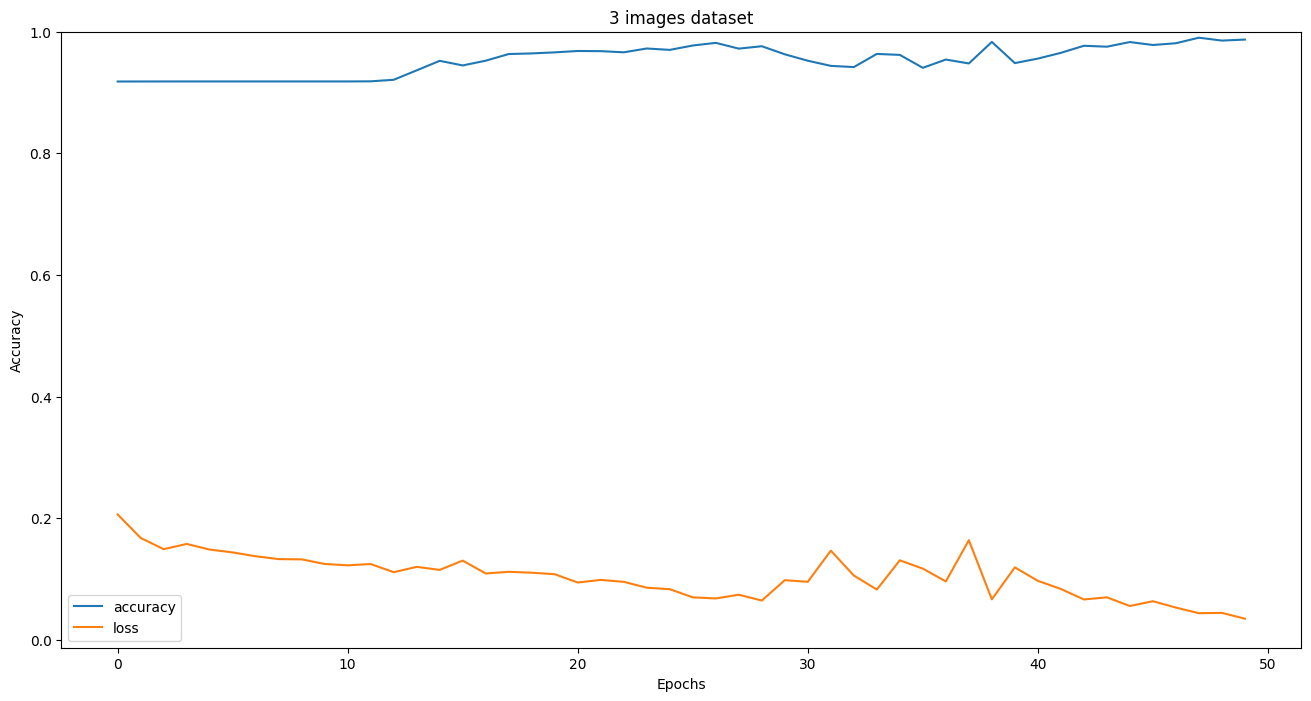

In [37]:
# Learning curve (Accuracy and loss on training dataset)
plt.figure(figsize=(16,8))
plt.title("3 images dataset")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["loss"], label="loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(ymax=1)  # this line
plt.legend()

#add curve of validation loss (if option is activated)

In [39]:
print(f'Evaluation (entrainement avec 3 images) : ')
model.evaluate(X_test, y_test)

Evaluation (entrainement avec 3 images) : 
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9080 - loss: 0.7850


[0.8130397200584412, 0.9054693579673767]

### Résultats entrainement avec tout le jeu de données

In [42]:
# Unet training
valid=0.0 # data validation percentage rate
earlystopper = EarlyStopping(patience=50, verbose=1)
#checkpointer = ModelCheckpoint('my_model_unet_mask_segmentation.h5', verbose=1, save_best_only=True, mode='min')
results = model.fit(X_train, y_train, validation_split=valid, batch_size=1, epochs=50)

Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9306 - loss: 0.2177
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.9867 - loss: 0.0369
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.9920 - loss: 0.0209
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.9948 - loss: 0.0138
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9956 - loss: 0.0112
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 7s 49ms/step - accuracy: 0.9965 - loss: 0.0086
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9967 - loss: 0.0084
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9969 - loss: 0.0077
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9973 - loss: 0.0067
Epoch 10/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.9967 - loss: 0.0081
Epoch 11/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.9974 - loss: 0.0064
Epoch 12/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 

In [43]:
#save model
model.save('./my_second_model.h5')

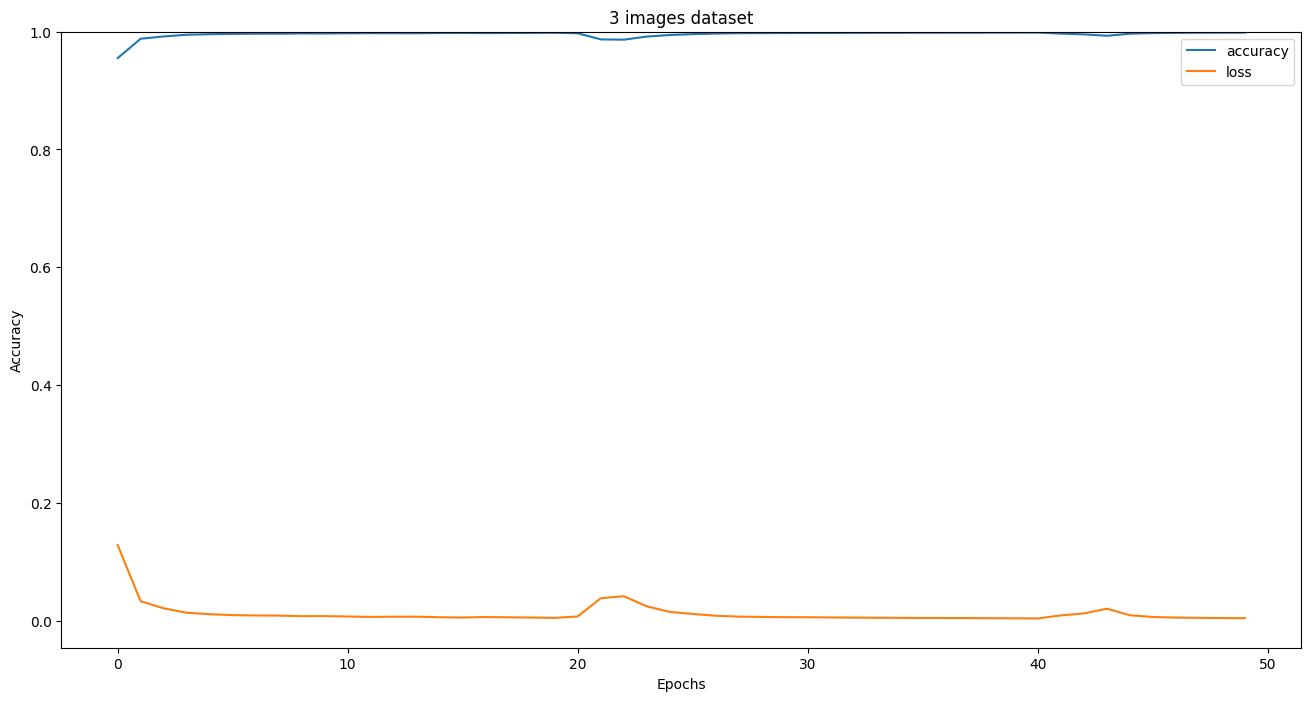

In [44]:
# Learning curve (Accuracy and loss on training dataset)
plt.figure(figsize=(16,8))
plt.title("3 images dataset")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["loss"], label="loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(ymax=1)  # this line
plt.legend()

#add curve of validation loss (if option is activated)

In [45]:
print(f'Evaluation (entrainement avec toutes les images) : ')
model.evaluate(X_test, y_test)

Evaluation (entrainement avec toutes les images) : 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9686 - loss: 0.9420 


[0.8017261624336243, 0.9717416167259216]

On aurait pu se demander s'il n'était pas plus judicieux d'entrainer notre modèle avec moins d'images mais on peut voir que pour des conditions d'entrainement égale notre modèle obtient de meilleurs résultats lorsque nous utilisons toutes les images.

On peut également rajouter que pour ce problème il est plus pertinant de faire du sur apprentissage étant donné que nos images se ressemblent toutes.

### Implémentation du Dice

In [85]:
#Implementation of Dice_loss for keras
def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# Implementarion DICE SCORE COEFFICIENT for testing of images
def dice(pred, true, k = 1):
    intersection = np.sum(pred[true==k]) * 2.0

    dice = intersection / (np.sum(pred == k) + np.sum(true == k))
    return dice

# Implementation HAUSDORFF DISTANCE for testing of images
def hausdorff_distance (pred, true):
  haus = max(directed_hausdorff(pred, true)[0], directed_hausdorff(true, pred)[0])
  return haus

In [ ]:
# Make a prediction with the best epoch
test_preds = model.predict(X_test)
preds_test_thresh = (test_preds >= 0.5).astype(np.uint8)
all_dice_testing=[]
all_hausdorff_testing=[]

for sujet_index in range (0,len(X_test)-1):
#for sujet_index in range (0,nb_images_testing-1):
  img_anat = X_test[sujet_index, :, :, 0]
  img_true = y_test[sujet_index, :, :, 0]
  img_pred = test_preds[sujet_index, :, :, 0]
  img_pred_th = preds_test_thresh[sujet_index, :, :, 0]

  # Calculation of segmentation quality metrics
  dice_score = dice(img_pred_th, img_true)

  # add dice score of all_dice_testing list
  all_dice_testing.append(dice_score)

  # compute hausdorff_distance between img_pred_th and img_true
  hausdorff_dist = hausdorff_distance(img_pred_th, img_true)
  # add metric in the all_hausdorff_testing list
  all_hausdorff_testing.append(hausdorff_dist)  

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step


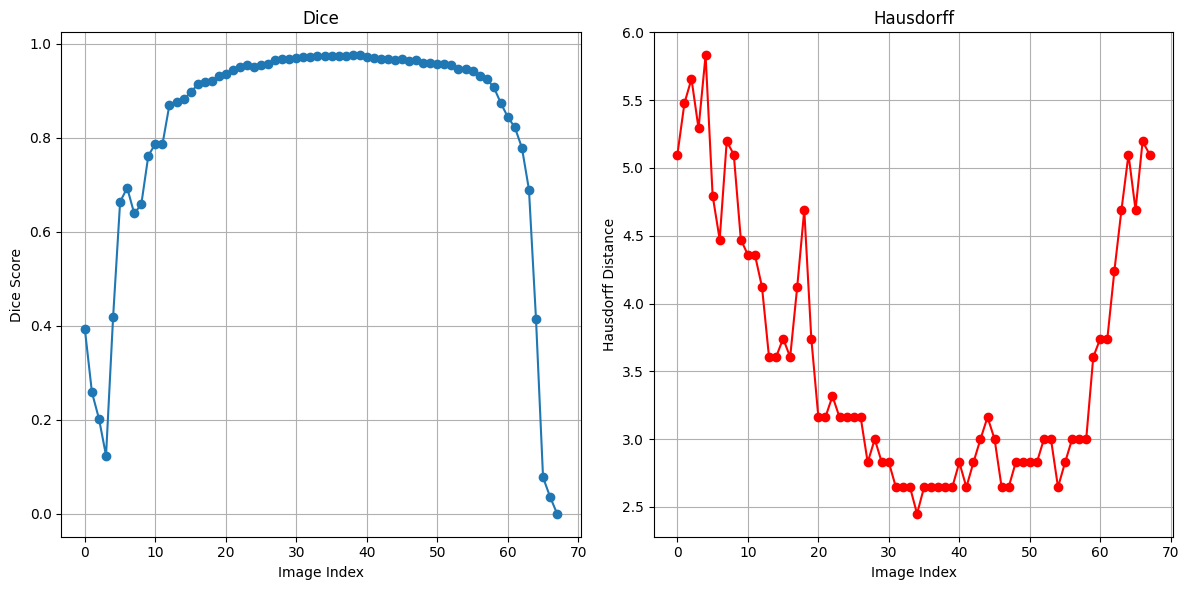

In [57]:
# plot on a figure the results ...
#use 2 subplots (the first for dice and second for HD)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.plot(all_dice_testing, marker='o', label='Dice Score')
plt.title('Dice')
plt.grid()
plt.xlabel('Image Index')
plt.ylabel('Dice Score')

plt.subplot(122)
plt.plot(all_hausdorff_testing, marker='o', color='r', label='Hausdorff Distance')
plt.title('Hausdorff')
plt.grid()
plt.xlabel('Image Index')
plt.ylabel('Hausdorff Distance')

plt.tight_layout()

On remarque sur ces courbes que nos résultats sont moins bons sur les images en bordure car c'est la que les masques de segmentation commencent à différer énormément. 

In [86]:
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    """
    intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(tf.square(y_true), axis=-1) + tf.reduce_sum(tf.square(y_pred), axis=-1) + smooth
    )

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [87]:
model = Model(inputs=[inputs], outputs=[outputs])
#test other loss function (loss=dice_coef_loss)
model.compile(optimizer='adam', loss=dice_coef_loss, metrics=['accuracy'])
model.summary()

# Unet training
valid=0.0 # data validation percentage rate
earlystopper = EarlyStopping(patience=50, verbose=1)
#checkpointer = ModelCheckpoint('my_model_unet_mask_segmentation.h5', verbose=1, save_best_only=True, mode='min')
results = model.fit(X_train, y_train, validation_split=valid, batch_size=1, epochs=50)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ lambda[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ dropout[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ dropout_2[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ dropout_3[0][0] 

 Total params: 1,940,817 (7.40 MB)

 Trainable params: 1,940,817 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - accuracy: 0.9974 - loss: 0.0011
Epoch 2/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9980 - loss: 8.1033e-04
Epoch 3/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9983 - loss: 7.0709e-04
Epoch 4/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.9983 - loss: 7.2713e-04
Epoch 5/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9986 - loss: 6.0984e-04
Epoch 6/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9984 - loss: 6.6930e-04
Epoch 7/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9983 - loss: 6.7988e-04
Epoch 8/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9985 - loss: 6.3608e-04
Epoch 9/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9987 - loss: 5.6426e-04
Epoch 10/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.9987 - loss: 5.6018e-04
Epoch 11/50
146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9930 - loss: 0.0032
Epoc

In [88]:
print(f'Evaluation (Dice loss) : ')
model.evaluate(X_test, y_test)

Evaluation (Dice loss) : 
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - accuracy: 0.9747 - loss: 0.0126 


[0.011514497920870781, 0.9767606258392334]

On peut voir que nous obtenons de meilleurs résultats d'entrainement ainsi que de test avec notre loss function dice plutot qu'avec notre cross entropy.

In [ ]:
plt.figure(figsize=(10,10))
plt.axis('Off')

Slide_row_1=...

# == row 1 ==
plt.subplot(3,3,1)
test_image = X_test[Slide_row_1, :, :, 0]
plt.imshow(test_image, cmap='gray')
plt.title('Test Image 01', fontsize=14)
plt.axis('off')

# true mask
plt.subplot(3,3,2)
true_mask=Y_test[Slide_row_1, :, :, 0]
plt.imshow(true_mask, cmap='gray')
plt.title('True Mask', fontsize=14)

plt.subplot(3,3,3)
inf_mask=test_preds[Slide_row_1, :, :, 0]
plt.imshow(inf_mask, cmap='gray')
plt.title('predicted Mask', fontsize=14)

plt.axis('off')

plt.tight_layout()
plt.show()

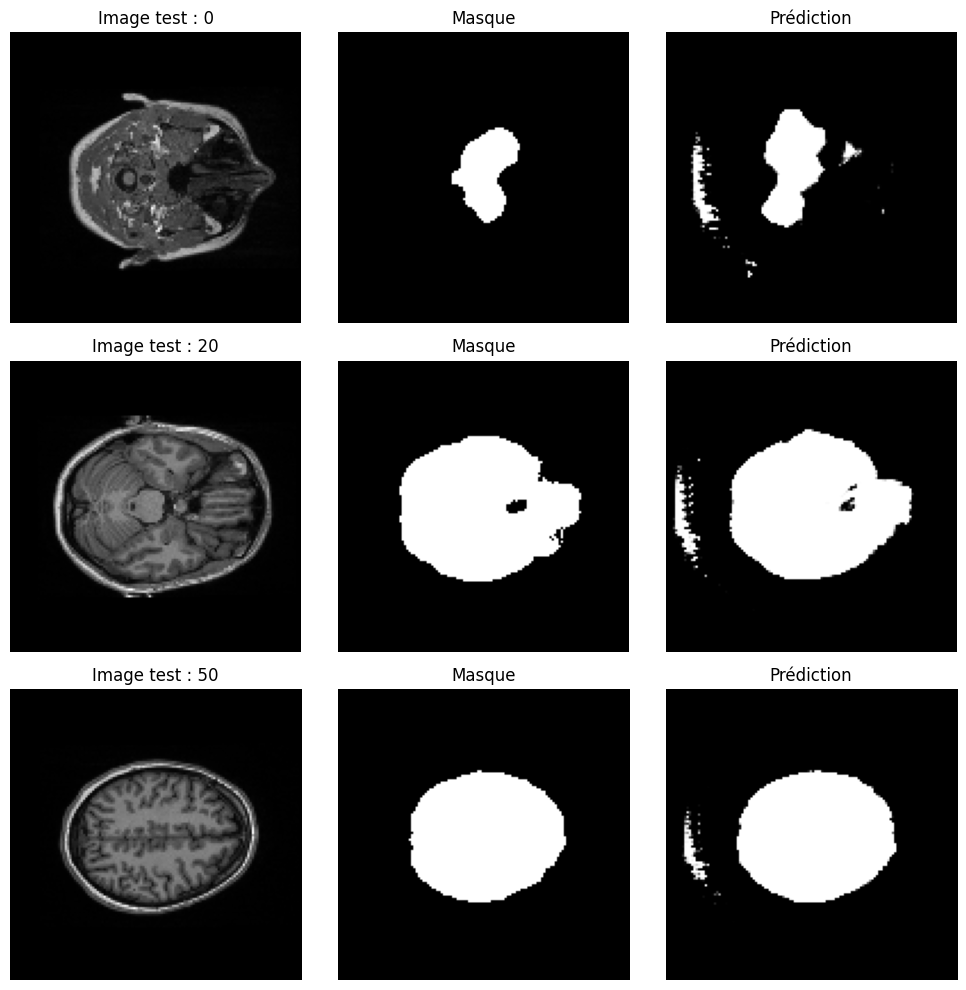

In [69]:
indices = [0, 20, 50] 

plt.figure(figsize=(10, 10))

for i, slide_index in enumerate(indices):
    
    plt.subplot(3, 3, i * 3 + 1)
    test_image = X_test[slide_index, :, :, 0]
    plt.imshow(test_image, cmap='gray')
    plt.title(f'Image test : {slide_index}')
    plt.axis('off')

    plt.subplot(3, 3, i * 3 + 2)
    true_mask = y_test[slide_index, :, :, 0]
    plt.imshow(true_mask, cmap='gray')
    plt.title('Masque')
    plt.axis('off')

    plt.subplot(3, 3, i * 3 + 3)
    inf_mask = test_preds[slide_index, :, :, 0]
    plt.imshow(inf_mask, cmap='gray')
    plt.title('Prédiction')
    plt.axis('off')

plt.tight_layout()


Comme dit plus tôt, les images centrales sont plus simples à segmenter car elles se ressemblent tandis que pour les images au bord, cela devient plus laborieux.

In [70]:
# Data Augmentation

from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
                        layers.RandomFlip(mode="horizontal_and_vertical", seed=1),
                        layers.RandomRotation(factor=0.20, fill_mode="constant", fill_value=0, seed=1),
                        layers.RandomZoom(height_factor=(0.3,-0.3), fill_mode='constant', fill_value=0, seed=1)])

X_train_augmented = X_train
Y_train_augmented = y_train

for x in range(5):
  ds_concatenate = np.concatenate((X_train_augmented,Y_train_augmented), axis=3)
  ds_concatenate_augmented=data_augmentation(ds_concatenate)

  X_train_augmented=ds_concatenate_augmented[:,:,:,0:1]
  X_train_augmented=np.concatenate((X_train,X_train_augmented), axis=0)

  Y_train_augmented=ds_concatenate_augmented[:,:,:,1:2]
  Y_train_augmented=np.concatenate((y_train,Y_train_augmented), axis=0)



In [71]:
print(X_train_augmented.shape)

(876, 128, 128, 1)


146


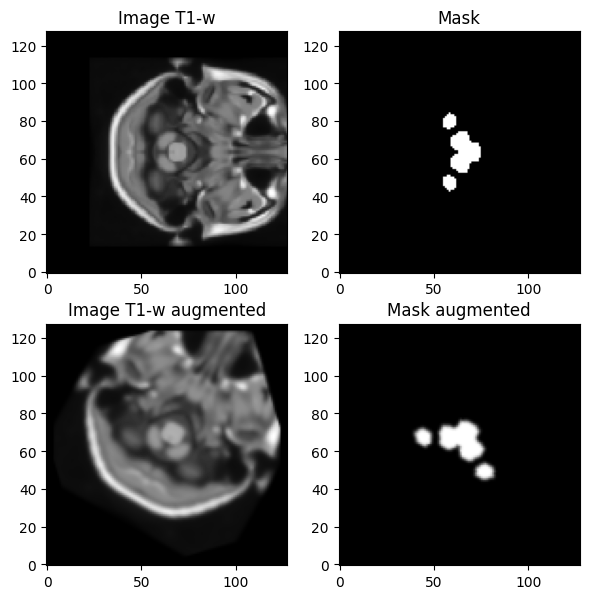

Total images for training without data augmentation =  146
Total images for training with data augmentation =  876


In [89]:
Y_train_augmented.shape
print (len(X_train))

plt.figure(figsize=(6,6))
plt.axis('off')
Slide_show=1
plt.subplot(2,2,1)
plt.imshow(X_train_augmented[Slide_show,:,:,0],cmap="gray", origin="lower")
plt.title('Image T1-w')
plt.subplot(2,2,2)
plt.title("Mask")
plt.imshow(Y_train_augmented[Slide_show,:,:,0],cmap="gray", origin="lower")
plt.tight_layout()
plt.subplot(2,2,3)
plt.imshow(X_train_augmented[Slide_show + 3*len(X_train),:,:,0],cmap="gray", origin="lower")
plt.title('Image T1-w augmented')
plt.subplot(2,2,4)
plt.title("Mask augmented")
plt.imshow(Y_train_augmented[Slide_show + 3*len(X_train) ,:,:,0],cmap="gray", origin="lower")
plt.tight_layout()
plt.show()

print("Total images for training without data augmentation = ",(X_train.shape)[0])
print("Total images for training with data augmentation = ", (X_train_augmented.shape)[0])

In [75]:
# Unet training
valid=0.0 # data validation percentage rate
earlystopper = EarlyStopping(patience=50, verbose=1)
CKPT_path = "augmented_model.weights.h5"
checkpointer = ModelCheckpoint(".keras", verbose=1, save_best_only=True, mode='min')
results = model.fit(X_train_augmented, Y_train_augmented, validation_split=valid, batch_size=15, epochs=50, callbacks=[earlystopper, checkpointer])
# for work without data augmentation reemplace X_train_augmented, Y_train_augmented for X_train, Y_train

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 212ms/step - accuracy: 0.8882 - loss: 0.0485
Epoch 2/50


c:\Users\Jalil\Desktop\Ecole\M2TSI\tpenv\lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
c:\Users\Jalil\Desktop\Ecole\M2TSI\tpenv\lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 207ms/step - accuracy: 0.8906 - loss: 0.0424
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step - accuracy: 0.8882 - loss: 0.0369
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step - accuracy: 0.8962 - loss: 0.0344
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step - accuracy: 0.8912 - loss: 0.0347
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step - accuracy: 0.8844 - loss: 0.0353
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 203ms/step - accuracy: 0.8883 - loss: 0.0333
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 12s 206ms/step - accuracy: 0.8929 - loss: 0.0322
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 248ms/step - accuracy: 0.8919 - loss: 0.0306
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 233ms/step - accuracy: 0.8949 - loss: 0.0296
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 13s 226ms/step - accuracy: 0.8932 - loss: 0.0296
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 14s 231ms/step - accuracy: 0.8967 - loss: 0.0285
Epoch 13/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 15s 249ms/st

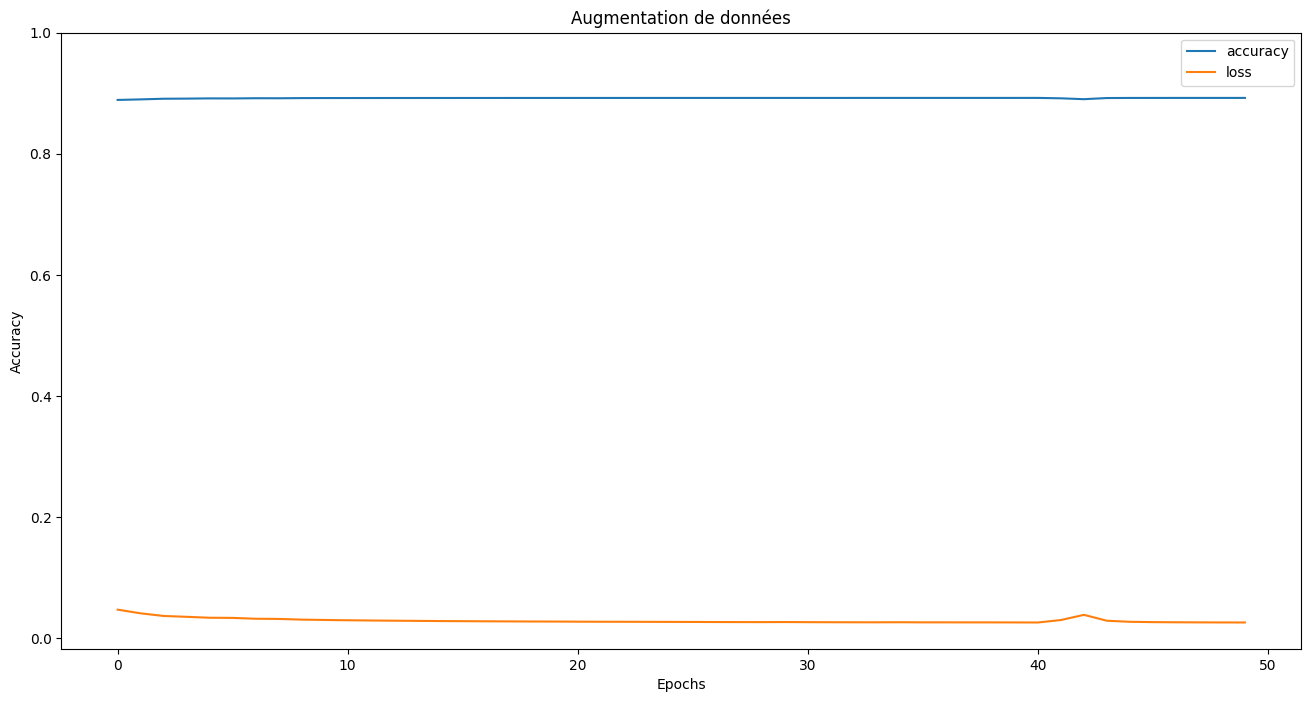

In [77]:
# Learning curve (Accuracy and loss on training dataset)
plt.figure(figsize=(16,8))
plt.title("Augmentation de données")
plt.plot(results.history["accuracy"], label="accuracy")
plt.plot(results.history["loss"], label="loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.ylim(ymax=1)  # this line
plt.legend()

#add curve of validation loss (if option is activated)

In [78]:
print(f'Evaluation (entrainement avec augmentation de données) : ')
model.evaluate(X_test, y_test)

Evaluation (entrainement avec augmentation de données) : 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9789 - loss: 0.6573 


[0.5496019124984741, 0.9814913272857666]

Dans notre cas l'augmentation de données ne permet pas d'augmenter la précision du modèle. De plus, il n'est pas pertinent dans notre cas de faire de l'augmentation de données étant données qu'avec cette modalité d'imagerie, les images seront toujours capturées de la même manière, ce qui rend inutile presque toutes les transformations. 